# Predictive Analysis & Early Detection of Brain stroke using Machine Learning Algorithm

## Imports and Settings

In [84]:
## import all the necessary libraries
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import joblib


In [ ]:
# Import scikit-learn components
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
)

In [86]:
# Import imbalanced-learn components
from imblearn.over_sampling import SMOTE


In [87]:
## Load the dataset
df = pd.read_csv("data.csv")

##### Exploratory Data Analysis

In [88]:
print("Dataset shape:", df.shape)

Dataset shape: (3356, 11)


In [89]:
# Types of data
print("\nData types:")
print(df.dtypes)


Data types:
gender                object
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [90]:
# Display the missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [91]:
# Visualizations
numerical_cols = ["age", "avg_glucose_level", "bmi"]
categorical_cols = ["gender", "work_type", "Residence_type", "smoking_status"]

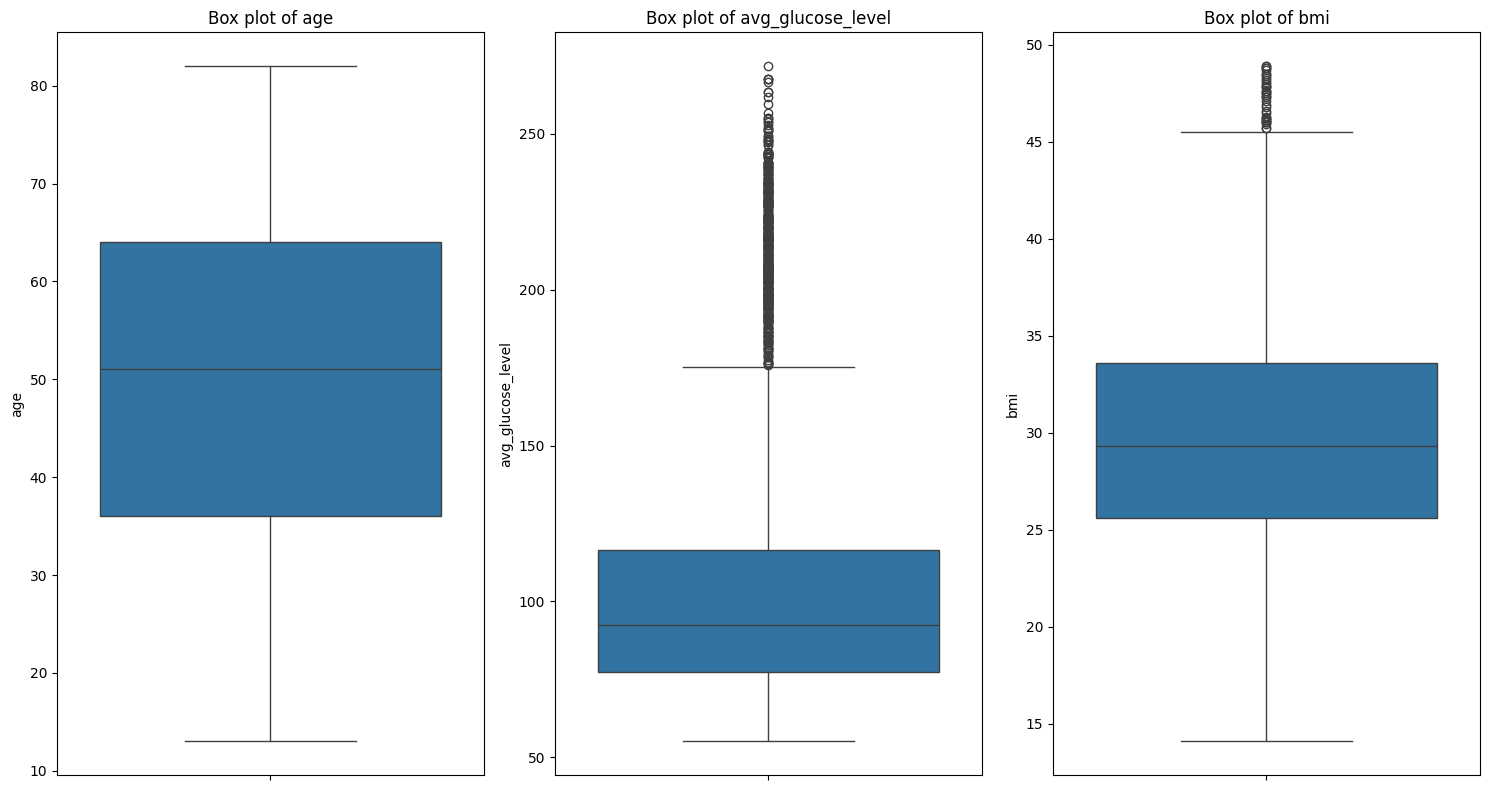

In [92]:
# Box plots for numerical columns
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Box plot of {col}")
plt.tight_layout()
plt.show()

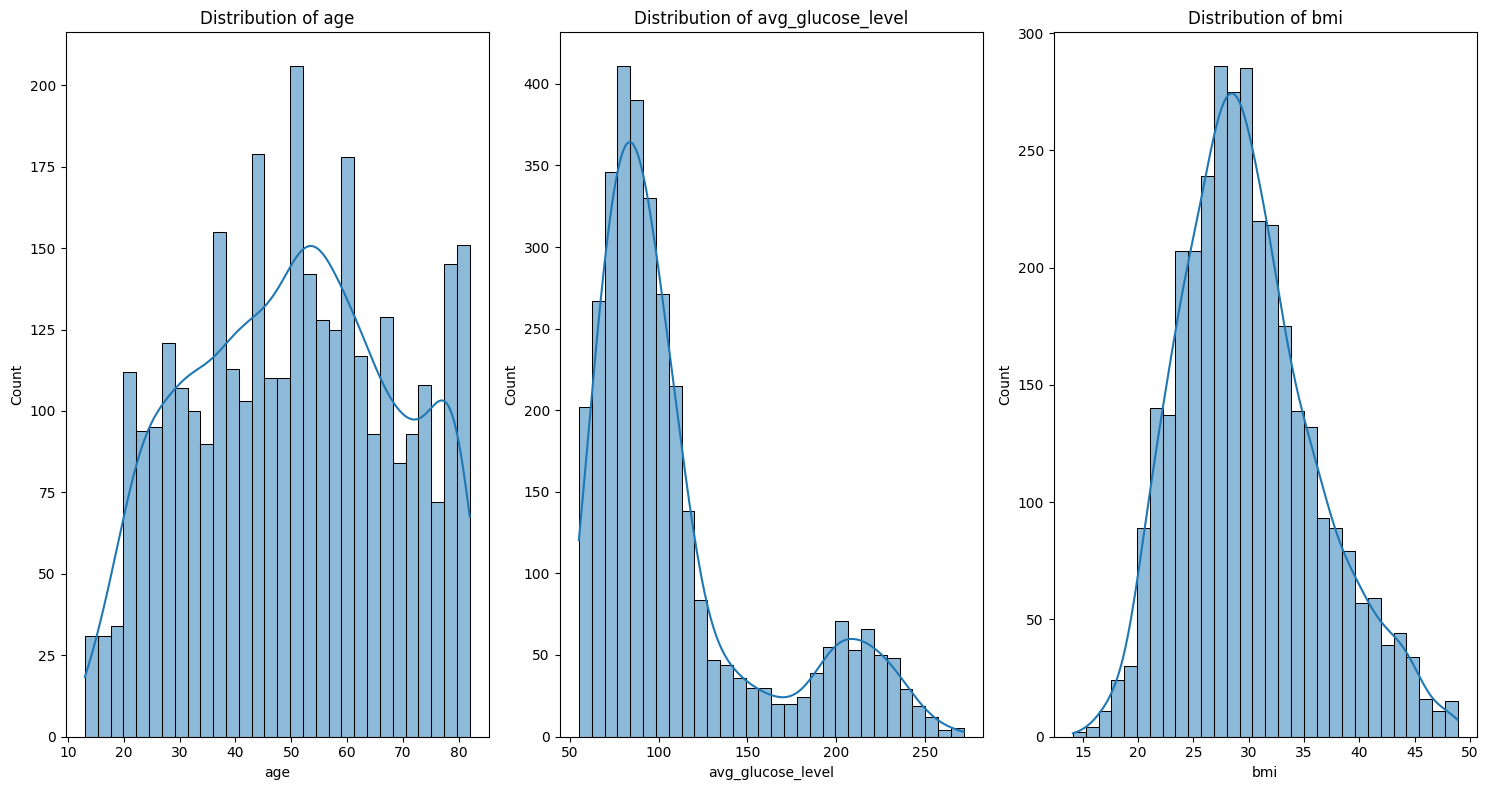

In [93]:
# Histograms for numerical columns
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

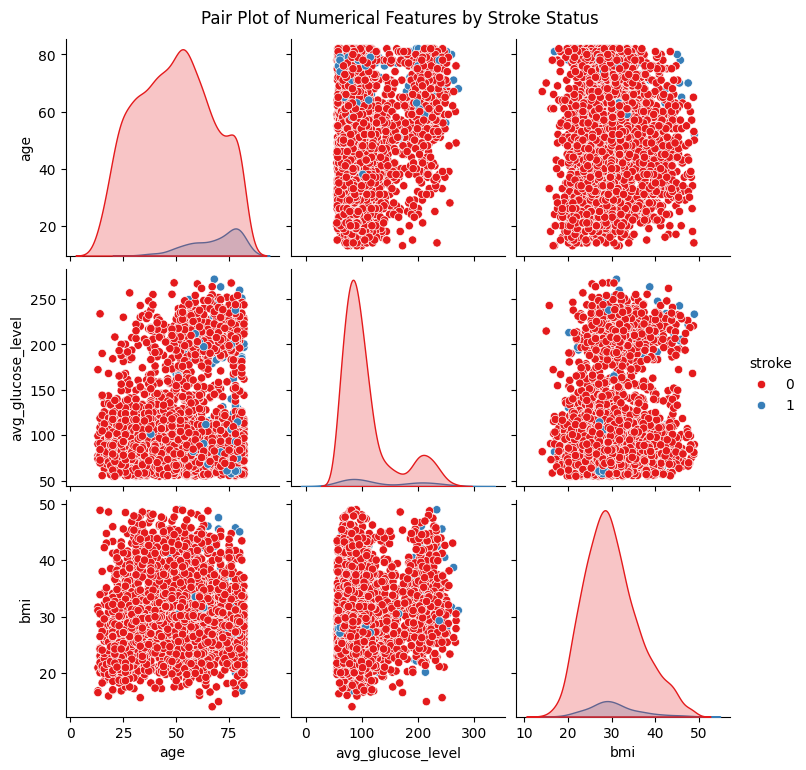

In [94]:
# Pair plot
sns.pairplot(df[numerical_cols + ["stroke"]], hue="stroke", palette="Set1")
plt.suptitle("Pair Plot of Numerical Features by Stroke Status", y=1.02)
plt.show()


Class distribution:


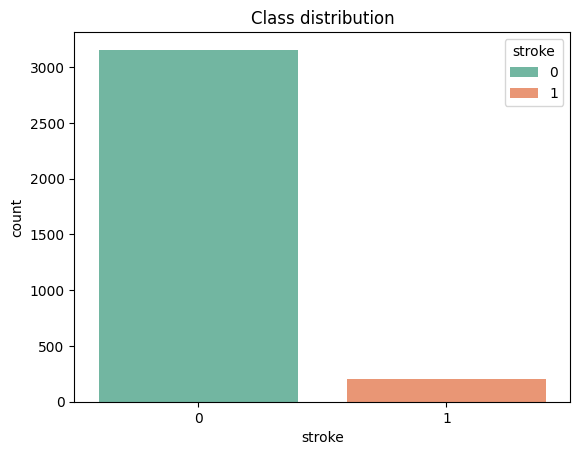

stroke
0    3155
1     201
Name: count, dtype: int64
Imbalance ratio: 1:15.7


In [95]:
# Class distribution
print("\nClass distribution:")
sns.countplot(x="stroke", data=df, hue="stroke", palette="Set2")
plt.title("Class distribution")
plt.show()
print(df["stroke"].value_counts())
print(
    f"Imbalance ratio: 1:{df['stroke'].value_counts().iloc[0] / df['stroke'].value_counts().iloc[1]:.1f}"
)

#####  Data Preprocessing

In [96]:
# Fill missing values
df.fillna({col: df[col].median() for col in numerical_cols}, inplace=True)
for col in categorical_cols:
    df.fillna({col: df[col].mode().iloc[0]}, inplace=True)

In [97]:
# Label encoding for categorical variables
le_dict = {}
for col in categorical_cols:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Encoded gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Encoded work_type: {'Govt_job': np.int64(0), 'Private': np.int64(1), 'Self-employed': np.int64(2)}
Encoded Residence_type: {'Rural': np.int64(0), 'Urban': np.int64(1)}
Encoded smoking_status: {'formerly smoked': np.int64(0), 'never smoked': np.int64(1), 'smokes': np.int64(2)}


In [ ]:
# Feature engineering
df["bmi_log"] = np.log(df["bmi"] + 1)
df["bmi_category"] = pd.cut(
    df["bmi"], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]
).astype("int64")
df["glucose_category"] = pd.cut(
    df["avg_glucose_level"], bins=[0, 100, 125, 200, 500], labels=[0, 1, 2, 3]
).astype("int64")
df["age_group"] = pd.cut(
    df["age"], bins=[0, 18, 40, 60, 100], labels=[0, 1, 2, 3]
).astype("int64")

In [99]:
# Remove low-correlation features
columns_to_drop = ["Residence_type", "ever_married", "work_type"]
df.drop(columns_to_drop, axis=1, inplace=True)
print(f"\nDropped columns due to low correlation: {columns_to_drop}")


Dropped columns due to low correlation: ['Residence_type', 'ever_married', 'work_type']


##### Principal Component Analysis

In [100]:
# Scale data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop("stroke", axis=1))

In [101]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df["stroke"] = df["stroke"].values

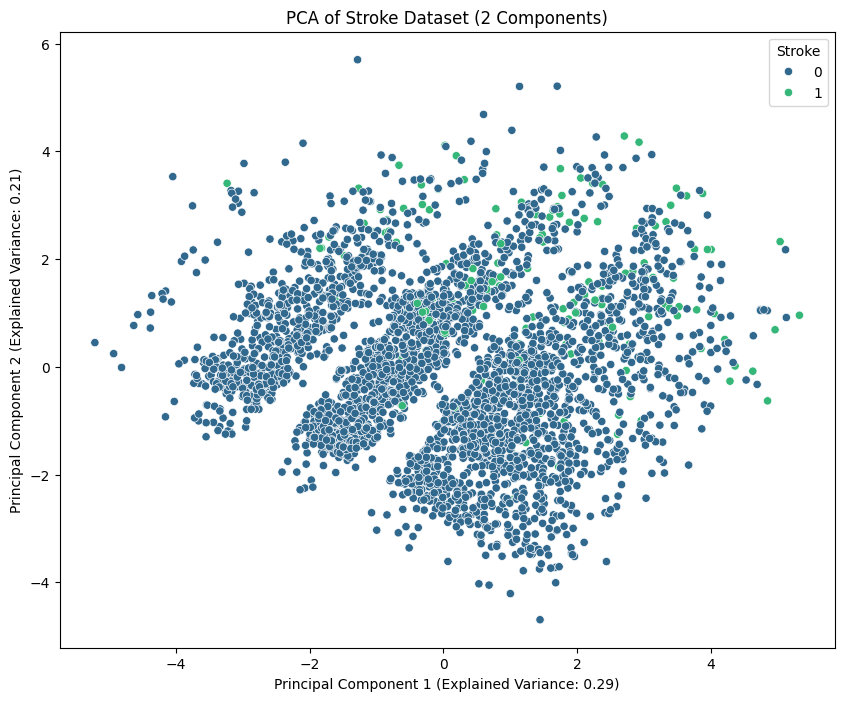

In [ ]:
# Visualize PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="stroke", data=pca_df, palette="viridis")
plt.legend(title="Stroke", labels=["No Stroke", "Stroke"])
plt.title("PCA of Stroke Dataset (2 Components)")
plt.xlabel(
    f"Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})"
)
plt.ylabel(
    f"Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})"
)
plt.legend(title="Stroke")
plt.show()

##### Model Training

In [ ]:
# Split data
X = df.drop("stroke", axis=1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [104]:
# Apply SMOTE for resampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [105]:
# Define models and parameter grids
models = {
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
}

param_grids = {
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
    },
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "class_weight": ["balanced", None],
    },
    "DecisionTree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "criterion": ["gini", "entropy"],
        "class_weight": ["balanced", None],
    },
}


Training and tuning KNN...

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       632
           1       0.10      0.38      0.16        40

    accuracy                           0.76       672
   macro avg       0.52      0.58      0.51       672
weighted avg       0.90      0.76      0.82       672



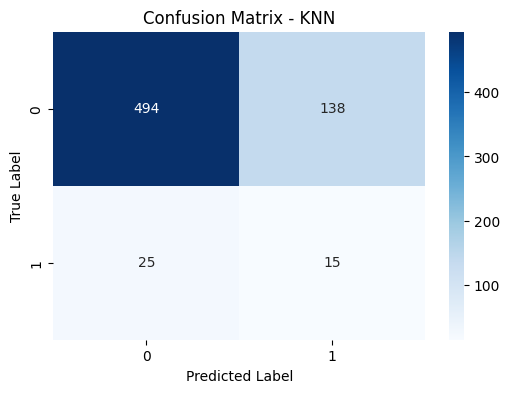


Training and tuning RandomForest...

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       632
           1       0.18      0.28      0.22        40

    accuracy                           0.88       672
   macro avg       0.57      0.60      0.58       672
weighted avg       0.91      0.88      0.89       672



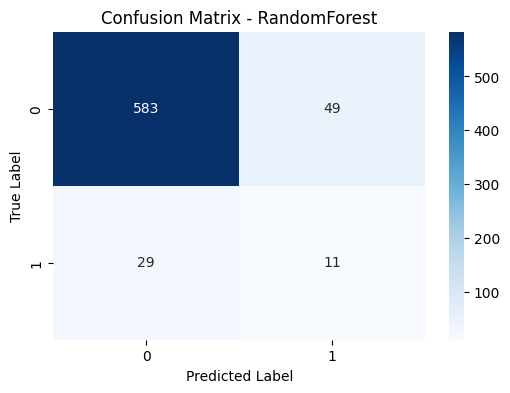


Training and tuning DecisionTree...

DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       632
           1       0.09      0.17      0.12        40

    accuracy                           0.85       672
   macro avg       0.52      0.53      0.52       672
weighted avg       0.89      0.85      0.87       672



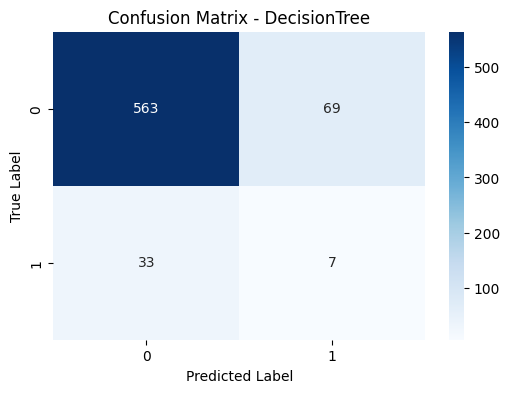

In [106]:
# Train and evaluate models
results = []
best_models = {}

for name, model in models.items():
    print(f"\nTraining and tuning {name}...")

    # Hyperparameter tuning
    search = RandomizedSearchCV(
        model,
        param_grids[name],
        n_iter=20,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )

    search.fit(X_resampled, y_resampled)
    best_model = search.best_estimator_
    best_models[name] = best_model

    # Make predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Calculate PR-AUC safely
    precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_pr, precision_pr)

    results.append(
        {
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc,
            "PR AUC": pr_auc,
        }
    )

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

##### Results Visualization

In [107]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
          Model  Accuracy  Precision  Recall  F1 Score   ROC AUC    PR AUC
0           KNN  0.757440   0.098039   0.375   0.15544  0.584375  0.123406
1  RandomForest  0.883929   0.183333   0.275   0.22000  0.726068  0.119204
2  DecisionTree  0.848214   0.092105   0.175   0.12069  0.532911  0.158106


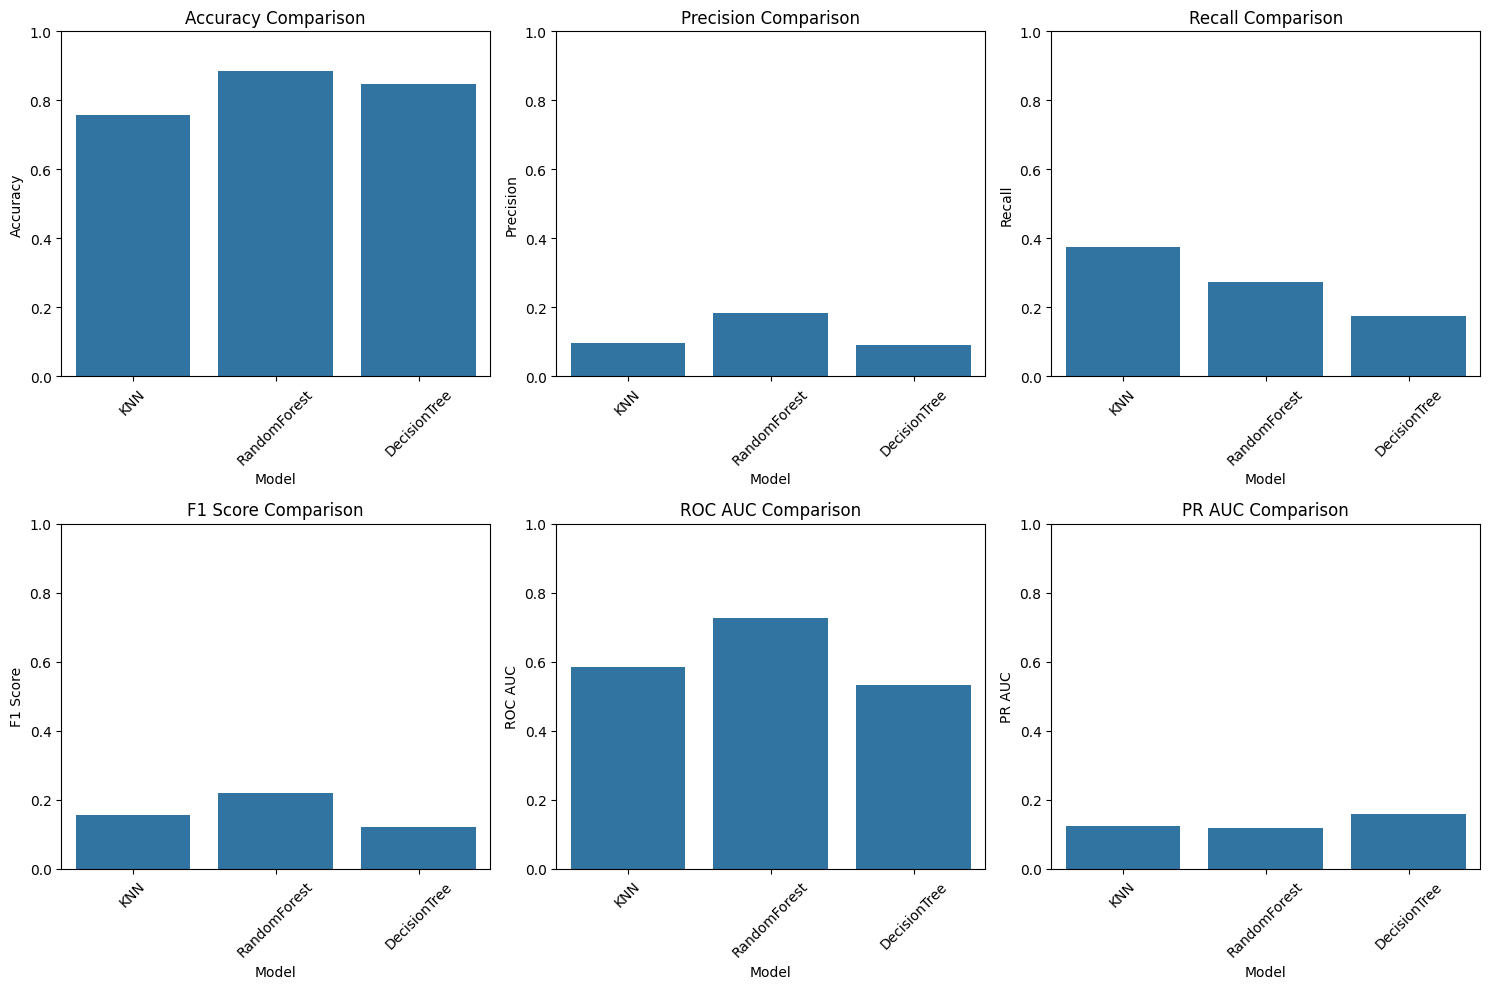

In [108]:
# Visualize model performance
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "PR AUC"]
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x="Model", y=metric, data=results_df)

    plt.title(f"{metric} Comparison")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

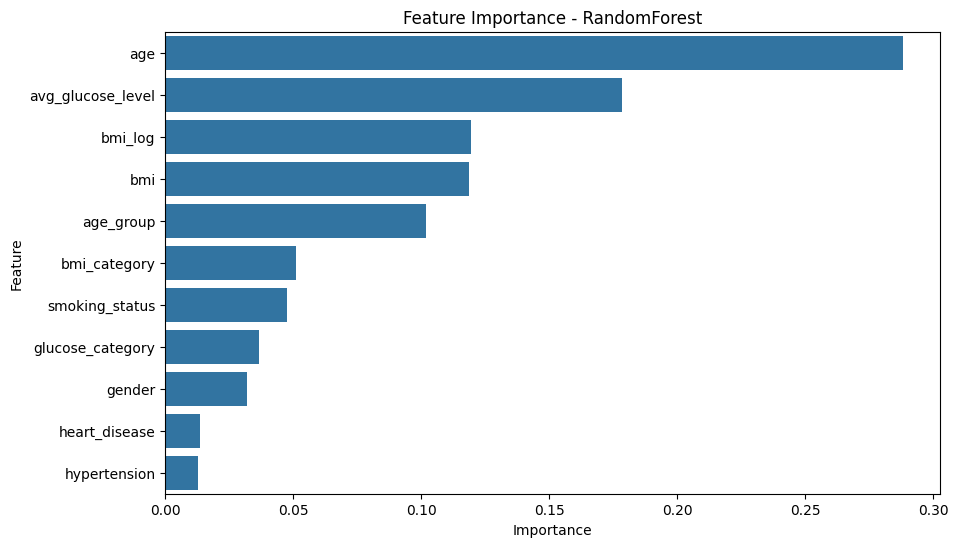

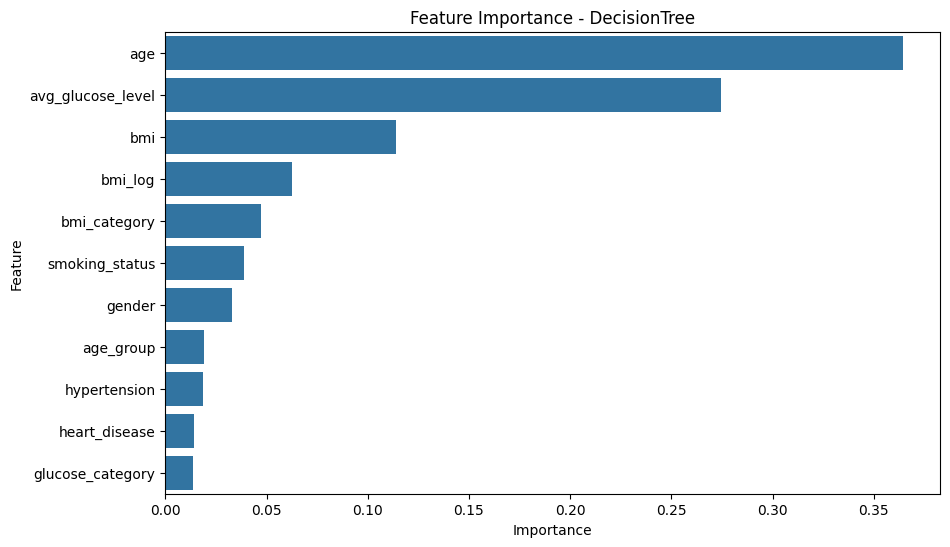

In [109]:
# Feature importance for tree-based models
for name, model in best_models.items():
    if hasattr(model, "feature_importances_"):
        importance = pd.DataFrame(
            {"Feature": X.columns, "Importance": model.feature_importances_}
        ).sort_values("Importance", ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x="Importance", y="Feature", data=importance)
        plt.title(f"Feature Importance - {name}")
        plt.show()

##### Final Model Selection

In [110]:
# Select best model based on F1 score
best_model_name = results_df.loc[results_df["F1 Score"].idxmax(), "Model"]
best_model = best_models[best_model_name]
print(f"\nBest model: {best_model_name}")
print(
    f"F1 Score: {results_df.loc[results_df['Model'] == best_model_name, 'F1 Score'].values[0]:.4f}"
)
print(
    f"Recall: {results_df.loc[results_df['Model'] == best_model_name, 'Recall'].values[0]:.4f}"
)
print(
    f"Precision: {results_df.loc[results_df['Model'] == best_model_name, 'Precision'].values[0]:.4f}"
)


Best model: RandomForest
F1 Score: 0.2200
Recall: 0.2750
Precision: 0.1833


In [111]:
# Save the best model
joblib.dump(best_model, f"best_stroke_model_{best_model_name}.pkl")
print(f"\nBest model saved as: best_stroke_model_{best_model_name}.pkl")


Best model saved as: best_stroke_model_RandomForest.pkl


##### Best Model Visualization

In [112]:
# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

In [113]:
# Calculate metrics for the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

In [114]:
# Calculate ROC-AUC for the best model
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

In [115]:
# Calculate PR-AUC for the best model
precision_pr_best, recall_pr_best, _ = precision_recall_curve(y_test, y_prob_best)
pr_auc_best = auc(recall_pr_best, precision_pr_best)

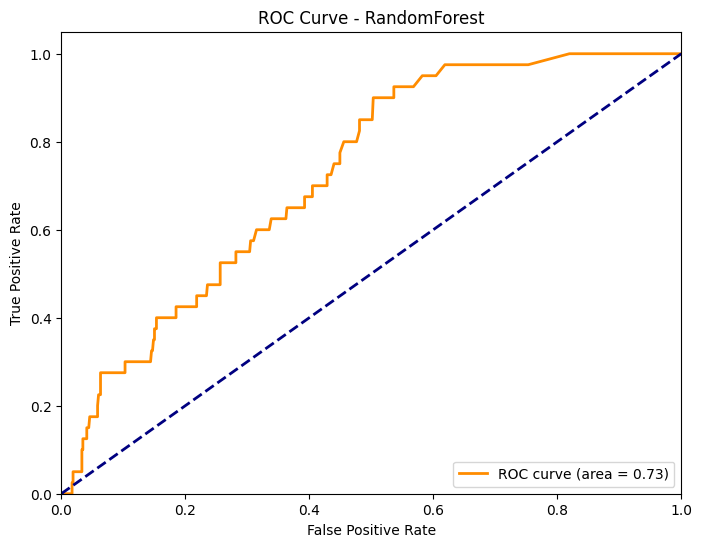

In [116]:
# Plot ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(
    fpr_best,
    tpr_best,
    color="darkorange",
    lw=2,
    label=f"ROC curve (area = {roc_auc_best:.2f})",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_model_name}")
plt.legend(loc="lower right")
plt.show()

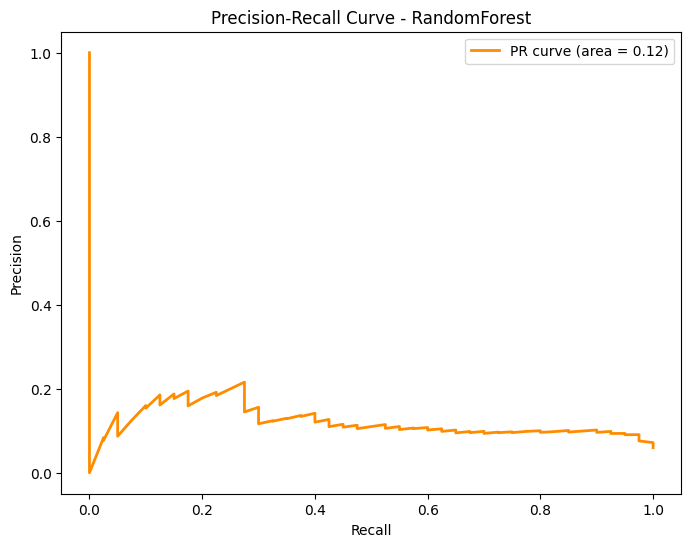

In [117]:
# Plot Precision-Recall curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(
    recall_pr_best,
    precision_pr_best,
    color="darkorange",
    lw=2,
    label=f"PR curve (area = {pr_auc_best:.2f})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve - {best_model_name}")
plt.legend(loc="best")
plt.show()

In [118]:
# Print classification report for the best model
print(f"\n{best_model_name} Classification Report:")
print(classification_report(y_test, y_pred_best))


RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       632
           1       0.18      0.28      0.22        40

    accuracy                           0.88       672
   macro avg       0.57      0.60      0.58       672
weighted avg       0.91      0.88      0.89       672

